## Customer Segmentation



In [3]:
import sys
sys.path.append('../')
from utils.imports import *
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

df = pd.read_csv('data/processed/customers_cleaned.csv')

df.head()

/home/guilherme/Documents/Projects/smart-buyer-assistant/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,userId,productId,rating,timestamp,year,month,day,rating_normalized,user_avg_rating,user_rating_std,user_total_ratings,user_unique_products,user_avg_normalized_rating,product_avg_rating,product_rating_std,product_total_ratings,product_unique_users,product_avg_normalized_rating
0,725046,0,5.000,2013-05-28,2013,5,28,1.000,4.250,0.957,4,4,0.812,5.000,NaN,1,1,1.000
1,814606,1,3.000,2012-12-14,2012,12,14,0.500,3.500,0.707,2,2,0.625,4.000,1.414,2,2,0.750
2,313101,1,5.000,2014-07-07,2014,7,7,1.000,5.000,NaN,1,1,1.000,4.000,1.414,2,2,0.750
3,291075,2,4.000,2013-10-24,2013,10,24,0.750,4.000,NaN,1,1,0.750,4.000,NaN,1,1,0.750
4,802842,3,1.000,2010-05-19,2010,5,19,0.000,1.000,0.000,9,9,0.000,1.000,NaN,1,1,0.000


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['year'] = df['timestamp'].dt.year

In [5]:
customer_features = df.groupby('userId').agg({
    'rating': ['mean', 'std', 'count'],
    'productId': 'nunique',
    'rating_normalized': 'mean',
    'year': ['min', 'max']
}).fillna(0)

In [6]:
customer_features.columns = [
    'avg_rating',
    'rating_std',
    'total_purchases',
    'unique_products',
    'avg_normalized_rating',
    'year_min',
    'year_max'
]

customer_features.head()

,avg_rating,rating_std,total_purchases,unique_products,avg_normalized_rating,year_min,year_max
userId,,,,,,,
0,5.000,0.000,1,1,1.000,2013,2013
1,5.000,0.000,1,1,1.000,2014,2014
2,3.000,0.000,1,1,0.500,2014,2014
3,5.000,0.000,1,1,1.000,2014,2014
4,5.000,0.000,1,1,1.000,2014,2014


In [7]:
customer_features['customer_lifetime_years'] = customer_features['year_max'] - customer_features['year_min'] + 1
customer_features['purchase_frequency'] = customer_features['total_purchases'] / customer_features['customer_lifetime_years']

In [8]:
customer_features = customer_features.replace([np.inf, -np.inf], np.nan)
customer_features = customer_features.fillna(0)

customer_features.head()

,avg_rating,rating_std,total_purchases,unique_products,avg_normalized_rating,year_min,year_max,customer_lifetime_years,purchase_frequency
userId,,,,,,,,,
0,5.000,0.000,1,1,1.000,2013,2013,1,1.000
1,5.000,0.000,1,1,1.000,2014,2014,1,1.000
2,3.000,0.000,1,1,0.500,2014,2014,1,1.000
3,5.000,0.000,1,1,1.000,2014,2014,1,1.000
4,5.000,0.000,1,1,1.000,2014,2014,1,1.000


In [9]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(customer_features)
features_scaled = pd.DataFrame(
    features_scaled, 
    columns=customer_features.columns,
    index=customer_features.index
)

features_scaled.head()

,avg_rating,rating_std,total_purchases,unique_products,avg_normalized_rating,year_min,year_max,customer_lifetime_years,purchase_frequency
userId,,,,,,,,,
0,0.687,-0.372,-0.265,-0.265,0.687,0.314,0.193,-0.281,-0.295
1,0.687,-0.372,-0.265,-0.265,0.687,0.924,0.842,-0.281,-0.295
2,-0.867,-0.372,-0.265,-0.265,-0.867,0.924,0.842,-0.281,-0.295
3,0.687,-0.372,-0.265,-0.265,0.687,0.924,0.842,-0.281,-0.295
4,0.687,-0.372,-0.265,-0.265,0.687,0.924,0.842,-0.281,-0.295


In [10]:
sample_size = 10000
sample_indices = np.random.choice(len(features_scaled), size=sample_size, replace=False)
features_sample = features_scaled.iloc[sample_indices]

inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_sample)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_sample, kmeans.labels_))

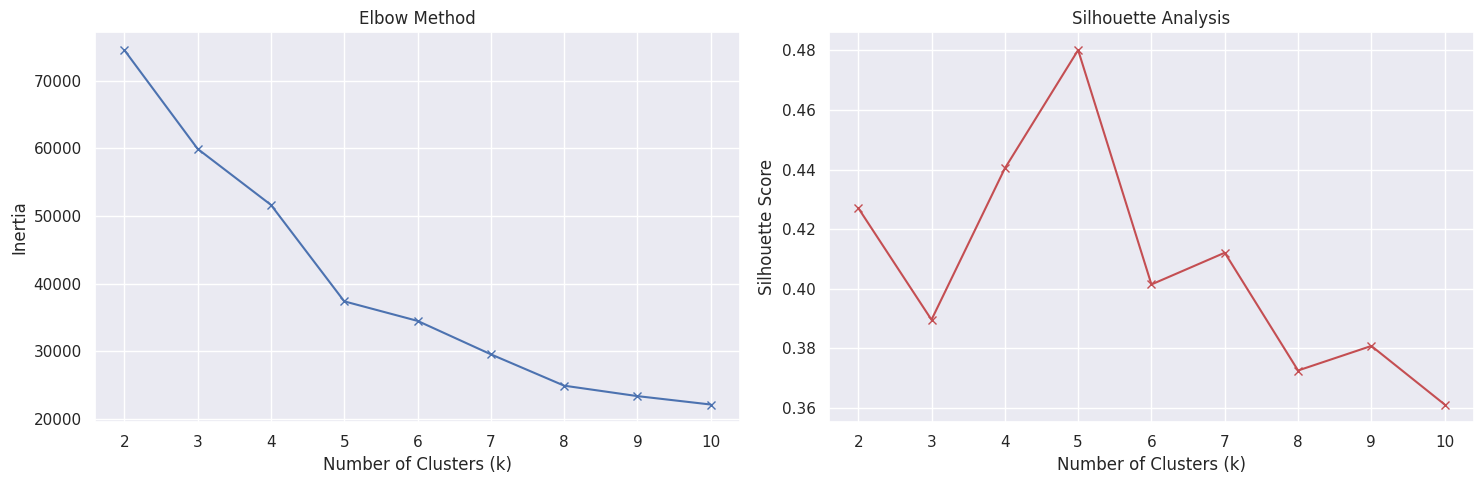

In [11]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

In [12]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(features_scaled)
customer_features.head()

,avg_rating,rating_std,total_purchases,unique_products,avg_normalized_rating,year_min,year_max,customer_lifetime_years,purchase_frequency,Cluster
userId,,,,,,,,,,
0,5.000,0.000,1,1,1.000,2013,2013,1,1.000,0
1,5.000,0.000,1,1,1.000,2014,2014,1,1.000,0
2,3.000,0.000,1,1,0.500,2014,2014,1,1.000,0
3,5.000,0.000,1,1,1.000,2014,2014,1,1.000,0
4,5.000,0.000,1,1,1.000,2014,2014,1,1.000,0


In [13]:
print("\nCluster Sizes:")
print(customer_features['Cluster'].value_counts())


Cluster Sizes:
Cluster
0    1033897
3     121743
1      50683
2       3948
Name: count, dtype: int64


In [14]:
cluster_means = customer_features.groupby('Cluster').mean()
print("\nCluster Characteristics:")
print(cluster_means)


Cluster Characteristics:
         avg_rating  rating_std  total_purchases  unique_products  \
Cluster                                                             
0             4.162       0.022            1.180            1.180   
1             4.238       0.786            4.340            4.340   
2             4.220       0.962           29.330           29.330   
3             3.672       1.433            3.841            3.841   

         avg_normalized_rating  year_min  year_max  customer_lifetime_years  \
Cluster                                                                       
0                        0.790  2012.576  2012.615                    1.039   
1                        0.809  2009.975  2013.211                    4.237   
2                        0.805  2011.554  2013.672                    3.118   
3                        0.668  2012.790  2013.199                    1.409   

         purchase_frequency  
Cluster                      
0                     1.

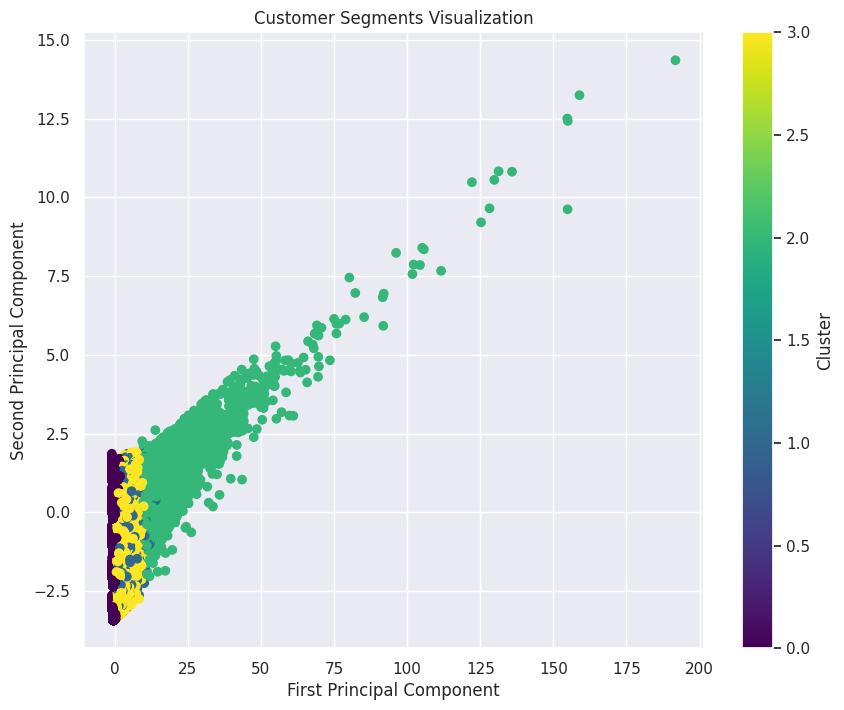

In [15]:
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], 
                     c=customer_features['Cluster'], 
                     cmap='viridis')
plt.title('Customer Segments Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar(scatter, label='Cluster')
plt.show()

In [16]:
def create_cluster_profile(cluster_id):
    cluster_data = customer_features[customer_features['Cluster'] == cluster_id]
    profile = {
        'Size': len(cluster_data),
        'Percentage': f"{(len(cluster_data) / len(customer_features)) * 100:.1f}%",
        'Avg Rating': f"{cluster_data['avg_rating'].mean():.2f}",
        'Purchases': f"{cluster_data['total_purchases'].mean():.1f}",
        'Purchase Frequency': f"{cluster_data['purchase_frequency'].mean():.2f}"
    }
    return profile

In [17]:
print("\nCustomer Segment Profiles:")
for i in range(optimal_k):
    print(f"\nCluster {i}:")
    profile = create_cluster_profile(i)
    for key, value in profile.items():
        print(f"{key}: {value}")


Customer Segment Profiles:

Cluster 0:
Size: 1033897
Percentage: 85.4%
Avg Rating: 4.16
Purchases: 1.2
Purchase Frequency: 1.13

Cluster 1:
Size: 50683
Percentage: 4.2%
Avg Rating: 4.24
Purchases: 4.3
Purchase Frequency: 1.09

Cluster 2:
Size: 3948
Percentage: 0.3%
Avg Rating: 4.22
Purchases: 29.3
Purchase Frequency: 12.23

Cluster 3:
Size: 121743
Percentage: 10.1%
Avg Rating: 3.67
Purchases: 3.8
Purchase Frequency: 2.94
